In [1]:
import pandas as pd
import logging
import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval
import numpy as np
from sklearn import metrics #roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from seisLM.utils import project_path

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
phasenet_ethz = {
  '0.05': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_ETHZ_train_frac_0.05_model_PhaseNet_seed_42_time_2024-08-11-16h-57m-27s/checkpoints/epoch=49-step=800.ckpt",
  '0.1': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_ETHZ_train_frac_0.1_model_PhaseNet_seed_42_time_2024-08-11-16h-59m-42s/checkpoints/epoch=49-step=2400.ckpt",
  '0.2': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_ETHZ_train_frac_0.2_model_PhaseNet_seed_42_time_2024-08-11-17h-01m-13s/checkpoints/epoch=48-step=3920.ckpt",
  '0.5': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_ETHZ_train_frac_0.5_model_PhaseNet_seed_42_time_2024-08-11-17h-03m-46s/checkpoints/epoch=37-step=6498.ckpt",
  '1.0': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_ETHZ_train_frac_1.0_model_PhaseNet_seed_42_time_2024-08-11-17h-04m-13s/checkpoints/epoch=37-step=13414.ckpt",
}


phasenet_geofon = {
  '0.05': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_GEOFON_train_frac_0.05_model_PhaseNet_seed_42_time_2024-08-11-16h-47m-30s/checkpoints/epoch=41-step=5208.ckpt",
  '0.1': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_GEOFON_train_frac_0.1_model_PhaseNet_seed_42_time_2024-08-11-16h-47m-30s/checkpoints/epoch=42-step=10965.ckpt",
  '0.2': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_GEOFON_train_frac_0.2_model_PhaseNet_seed_42_time_2024-08-11-16h-47m-30s/checkpoints/epoch=26-step=13392.ckpt",
  '0.5': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_GEOFON_train_frac_0.5_model_PhaseNet_seed_42_time_2024-08-11-16h-47m-31s/checkpoints/epoch=28-step=36801.ckpt",
  '1.0': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/phasenet_GEOFON_train_frac_1.0_model_PhaseNet_seed_42_time_2024-08-11-16h-47m-31s/checkpoints/epoch=20-step=52920.ckpt",
}


seislm_ethz = {
  '0.05': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_ETHZ_train_frac_0.05_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-20h-00m-41s/checkpoints/epoch=40-step=656.ckpt", 
  '0.1': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_ETHZ_train_frac_0.1_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-20h-06m-11s/checkpoints/epoch=41-step=2016.ckpt",
  '0.2': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_ETHZ_train_frac_0.2_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-20h-14m-40s/checkpoints/epoch=44-step=3600.ckpt",
  '0.5': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_ETHZ_train_frac_0.5_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-20h-26m-11s/checkpoints/epoch=36-step=6327.ckpt",
  '1.0': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_ETHZ_train_frac_1.0_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-20h-46m-05s/checkpoints/epoch=46-step=16591.ckpt"
}

seislm_geofon = {
  '0.05': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_GEOFON_train_frac_0.05_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-18h-36m-00s/checkpoints/epoch=38-step=4836.ckpt",
  '0.1': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_GEOFON_train_frac_0.1_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-18h-36m-01s/checkpoints/epoch=46-step=11985.ckpt",
  '0.2': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_GEOFON_train_frac_0.2_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-19h-01m-20s/checkpoints/epoch=49-step=24800.ckpt",
  '0.5': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_GEOFON_train_frac_0.5_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-19h-13m-26s/checkpoints/epoch=48-step=62181.ckpt",
  '1.0': "/home/liu0003/Desktop/projects/seisLM/results/models/phasepick_run/seisLM_convpos_GEOFON_train_frac_1.0_model_MultiDimWav2Vec2ForFrameClassification_seed_42_time_2024-08-12-19h-25m-23s/checkpoints/epoch=36-step=93240.ckpt",
}

all_ckpt_dicts = {
  ('ethz', 'MultiDimWav2Vec2ForFrameClassification'): seislm_ethz,
  ('geofon', 'MultiDimWav2Vec2ForFrameClassification'): seislm_geofon,
  ('ethz', 'PhaseNet'): phasenet_ethz,
  ('geofon', 'PhaseNet'): phasenet_geofon,
}

# Taks 1 - event detection

In [3]:
def get_results_event_detection(pred_path):
  pred = pd.read_csv(pred_path)
  pred["trace_type_bin"] = pred["trace_type"] == "earthquake"

  fpr, tpr, _ = metrics.roc_curve(pred["trace_type_bin"], pred["score_detection"])
  prec, recall, thr = metrics.precision_recall_curve(
    pred["trace_type_bin"], pred["score_detection"]
  )

  f1 = 2 * prec * recall / (prec + recall)
  f1_threshold = thr[np.nanargmax(f1)]
  best_f1 = np.max(f1)

  return {
    'fpr': fpr,
    'tpr': tpr,
    'prec': prec,
    'recall': recall,
    'f1': f1,
    'f1_threshold': f1_threshold,
    'best_f1': best_f1
  }

def get_results_phase_identification(pred_path):
  pred = pd.read_csv(pred_path)
  pred["phase_label_bin"] = pred["phase_label"] == "P"
  fpr, tpr, _ = metrics.roc_curve(pred["phase_label_bin"], pred["score_p_or_s"])
  prec, recall, thr = metrics.precision_recall_curve(pred["phase_label_bin"], pred["score_p_or_s"])
  f1 = 2 * prec * recall / (prec + recall)
  f1_threshold = thr[np.nanargmax(f1)]
  best_f1 = np.nanmax(f1)

  return {
    'fpr': fpr,
    'tpr': tpr,
    'prec': prec,
    'recall': recall,
    'f1': f1,
    'f1_threshold': f1_threshold,
    'best_f1': best_f1
  }

def get_results_onset_determination(pred_path):
  pred = pd.read_csv(pred_path)
  results = {}
  for phase in ['P', 'S']:
    pred_phase = pred[pred["phase_label"] == phase]
    pred_col = f"{phase.lower()}_sample_pred"
    diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase["sampling_rate"]
    results[f'{phase}_onset_diff'] = diff
  return results


training_fracs = ['0.05', '0.1', '0.2', '0.5', '1.0']

In [4]:
eval_set = 'test'
data_name = 'geofon'

event_detection_results_seislm = {}
event_detection_results_phasenet = {}

phase_identification_results_seislm = {}
phase_identification_results_phasenet = {}

onset_determination_results_seislm = {}
onset_determination_results_phasenet = {}

for train_frac in training_fracs:

  if data_name == 'ethz':
    seislm_path = seislm_ethz[train_frac]
    phasenet_path = phasenet_ethz[train_frac]
  elif data_name == 'geofon':
    seislm_path = seislm_geofon[train_frac]
    phasenet_path = phasenet_geofon[train_frac]
  else:
    raise ValueError(f"Unknown data_name: {data_name}")

  comparing_ckpts = {
    'seislm': seislm_path,
    'phasenet': phasenet_path,
  }

  for ckpt_name, ckpt_path in comparing_ckpts.items():

    save_tag = ckpt_path.split('/')[-3]


    base_pred_path = (
      Path(project_path.EVAL_SAVE_DIR)
      / f"{save_tag}_{data_name}"
    )

    event_detection_results = get_results_event_detection(
      base_pred_path / f"{eval_set}_task1.csv")

    phase_identification_results = get_results_phase_identification(
      base_pred_path / f"{eval_set}_task23.csv"
    )

    onset_determination_results = get_results_onset_determination(
      base_pred_path / f"{eval_set}_task23.csv"
    )

    if ckpt_name == 'seislm':
      event_detection_results_seislm[train_frac] = event_detection_results
      phase_identification_results_seislm[train_frac] = phase_identification_results
      onset_determination_results_seislm[train_frac] = onset_determination_results

    elif ckpt_name == 'phasenet':
      event_detection_results_phasenet[train_frac] = event_detection_results
      phase_identification_results_phasenet[train_frac] = phase_identification_results
      onset_determination_results_phasenet[train_frac] = onset_determination_results
    else:
      raise ValueError(f"Unknown ckpt_name: {ckpt_name}")


In [5]:
phasenet_kwargs = {
  'label': 'PhaseNet',
  'color': '#fc8d59',
  'linestyle': '--',
  'lw': 2,
}

seislm_kwargs = {
  'label': 'SeisLM',
  'color': '#1b7837',
  'linestyle': '-',
  'lw': 2,
}


## Task 1

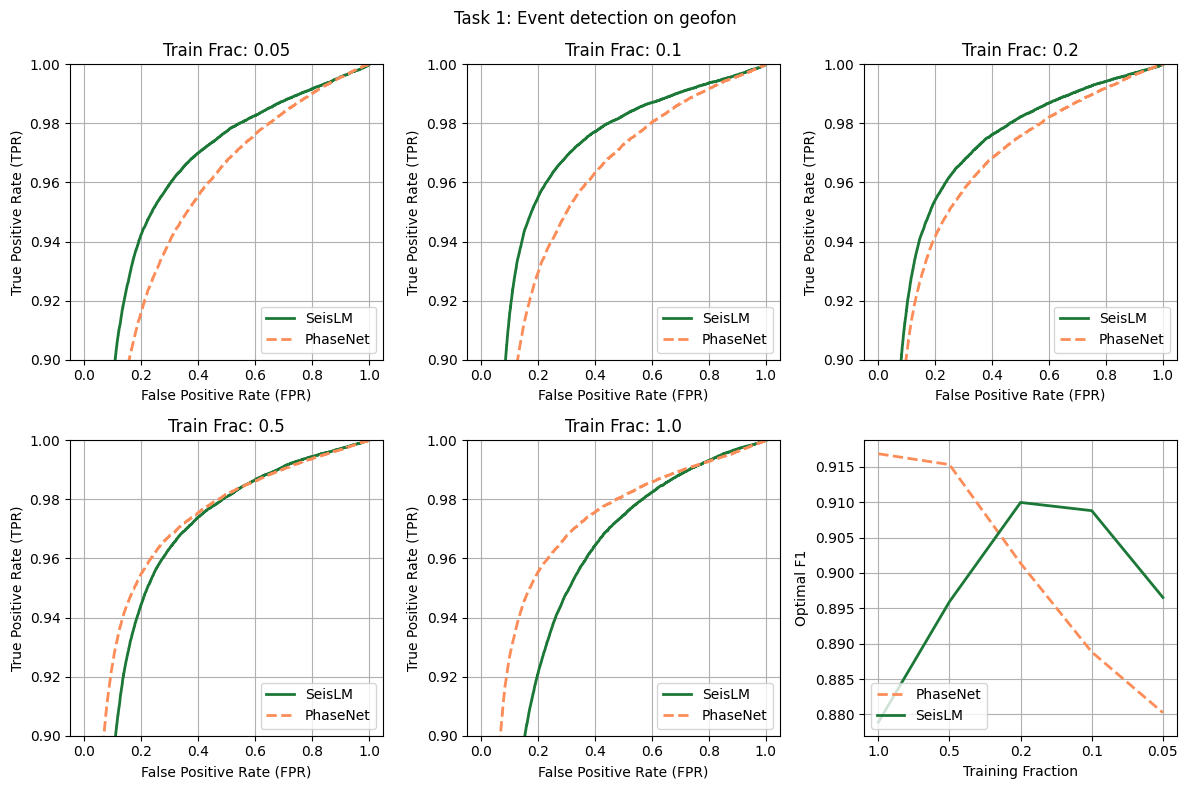

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

# Initialize variables to store the handles and labels for the legend
handles, labels = None, None

for i, train_frac in enumerate(training_fracs):
    ax = axes[i]
    line1, = ax.plot(
        event_detection_results_seislm[train_frac]['fpr'],
        event_detection_results_seislm[train_frac]['tpr'],
        ** seislm_kwargs
        # label='seislm',
        # color=colors['seislm'],
        # ls=linestyle['seislm'],
        # marker=markers['seislm']
    )
    line2, = ax.plot(
        event_detection_results_phasenet[train_frac]['fpr'],
        event_detection_results_phasenet[train_frac]['tpr'],
        ** phasenet_kwargs
        # label='phasenet',
        # color=colors['phasenet'],
        # ls=linestyle['phasenet'],
        # marker=markers['phasenet']
    )
    ax.set_ylim([0.9, 1])
    ax.set_title(f'Train Frac: {train_frac}')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(True)
    ax.legend(loc='lower right')
    # Capture the handles and labels for the legend
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()


axes[-1].plot(
  training_fracs[::-1],
  [event_detection_results_phasenet[training_frac]['best_f1'] for training_frac in training_fracs[::-1]],
  ** phasenet_kwargs
  # label='phasenet',
  # color=colors['phasenet'],
  # marker=markers['phasenet']
  # ls=linestyle['phasenet']
)

axes[-1].plot(
  training_fracs[::-1],
  [event_detection_results_seislm[training_frac]['best_f1'] for training_frac in training_fracs[::-1]],
  ** seislm_kwargs
  # label='seislm',
  # color=colors['seislm'],
  # marker=markers['seislm']
  # ls=linestyle['seislm']
)

axes[-1].set_xlabel("Training Fraction")
axes[-1].set_ylabel("Optimal F1")
axes[-1].grid()
axes[-1].legend(loc='lower left')

plt.suptitle(f'Task 1: Event detection on {data_name}')
plt.tight_layout()
plt.show()

# Task 2

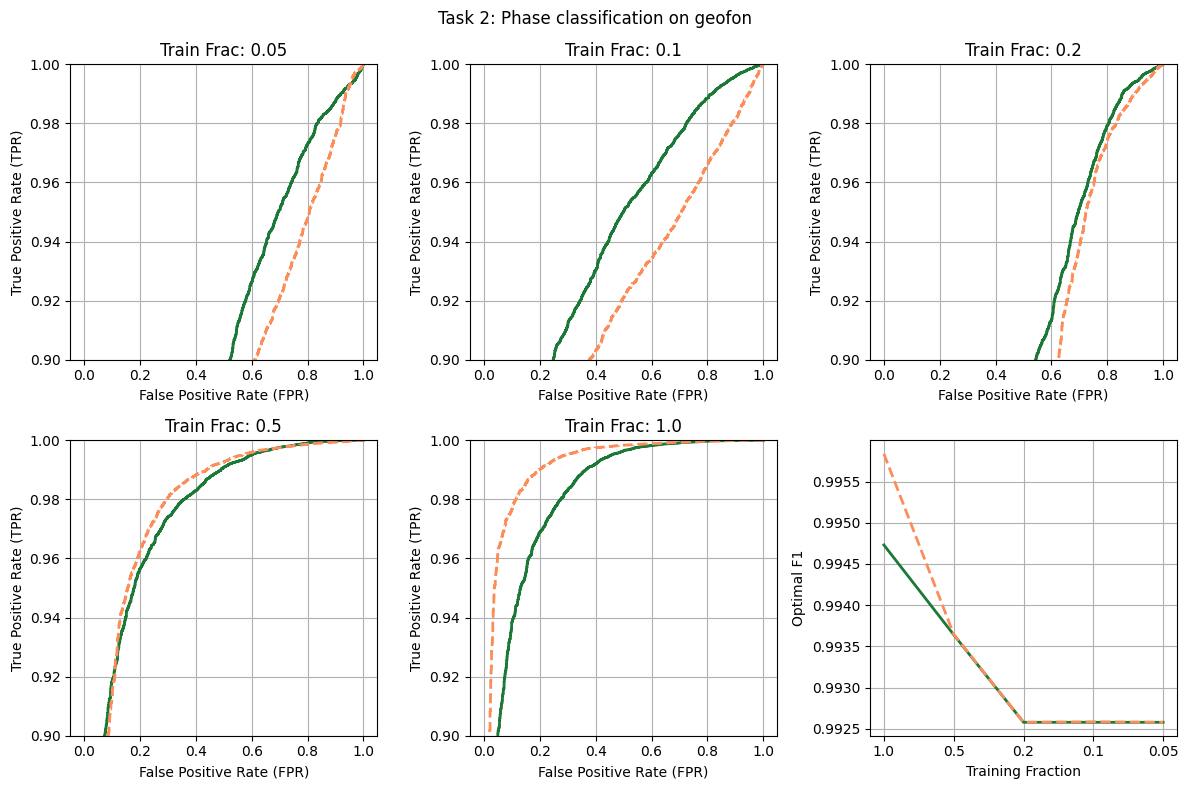

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

# Initialize variables to store the handles and labels for the legend
handles, labels = None, None

for i, train_frac in enumerate(training_fracs):
    ax = axes[i]
    line1, = ax.plot(
        phase_identification_results_seislm[train_frac]['fpr'],
        phase_identification_results_seislm[train_frac]['tpr'],
        # label='seislm'
        ** seislm_kwargs
    )
    line2, = ax.plot(
        phase_identification_results_phasenet[train_frac]['fpr'],
        phase_identification_results_phasenet[train_frac]['tpr'],
        # label='phasenet'
        ** phasenet_kwargs
    )
    ax.set_ylim([0.9, 1])
    ax.set_title(f'Train Frac: {train_frac}')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(True)

    # Capture the handles and labels for the legend
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

# Use the last panel for the legend

# axes[-1].legend(handles=handles, labels=labels, loc='center', fontsize='large')
# axes[-1].axis('off')  # Hide axes for the legend panel

axes[-1].plot(
  training_fracs[::-1],
  [phase_identification_results_seislm[training_frac]['best_f1'] for training_frac in training_fracs[::-1]],
  ** seislm_kwargs
)

axes[-1].plot(
  training_fracs[::-1],
  [phase_identification_results_phasenet[training_frac]['best_f1'] for training_frac in training_fracs[::-1]],
  ** phasenet_kwargs
)

axes[-1].set_xlabel("Training Fraction")
axes[-1].set_ylabel("Optimal F1")
axes[-1].grid()


plt.suptitle(f'Task 2: Phase classification on {data_name}')

plt.tight_layout()
plt.show()

# Task 3

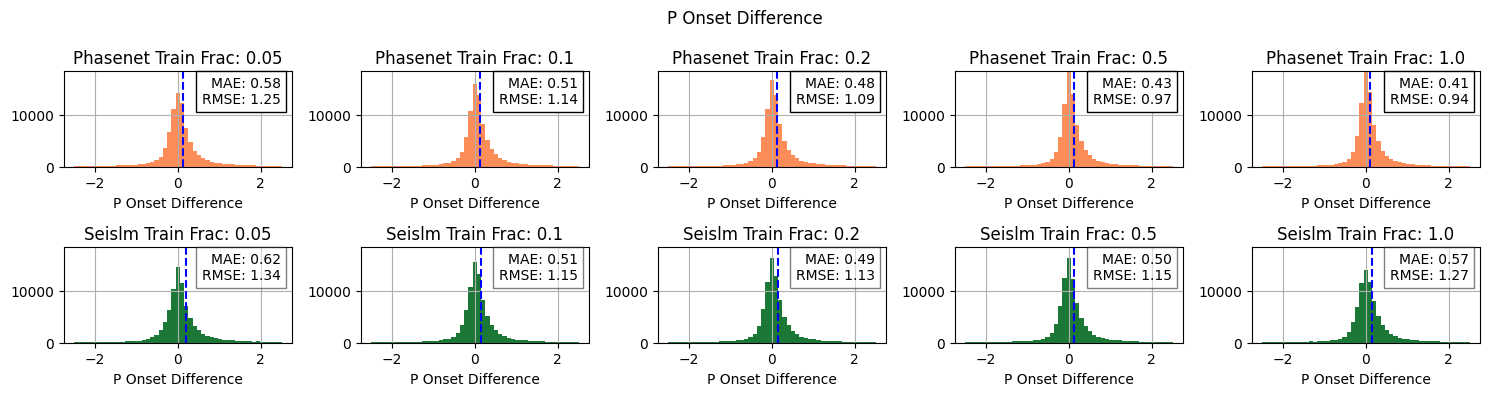

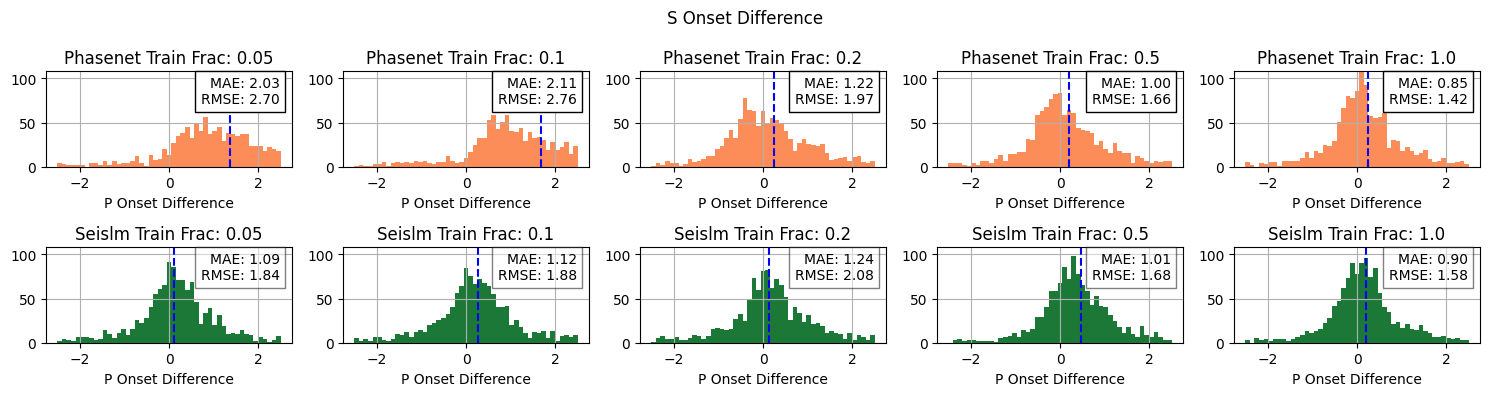

In [9]:
bins = np.linspace(-2.5, 2.5, 50)

# Create the subplots

for onset_type in ['P_onset_diff', 'S_onset_diff']:
  fig, axes = plt.subplots(2, 5, figsize=(15, 4))
  axes = axes.ravel()  # Flatten the axes array for easier iteration

  max_y = 0

  # Loop through each training fraction and subplot index to calculate histograms and find the maximum y-limit
  for i, train_frac in enumerate(training_fracs):
      # Data for phasenet and seislm
      phasenet_data = onset_determination_results_phasenet[train_frac][onset_type]
      seislm_data = onset_determination_results_seislm[train_frac][onset_type]

      # Plot the histogram for phasenet
      counts, _, _ = axes[i].hist(phasenet_data, bins)
      # Update max_y if necessary
      max_y = max(max_y, counts.max())

      # Plot the histogram for seislm
      counts, _, _ = axes[i + 5].hist(seislm_data, bins)
      # Update max_y if necessary
      max_y = max(max_y, counts.max())

  # Now set the y-limits to the same max_y value for all subplots
  for ax in axes:
      ax.set_ylim(0, max_y)

  # Loop through each training fraction and subplot index
  for i, train_frac in enumerate(training_fracs):
      # Data for phasenet and seislm
      phasenet_data = onset_determination_results_phasenet[train_frac][onset_type]
      seislm_data = onset_determination_results_seislm[train_frac][onset_type]

      # Calculate statistics for phasenet
      phasenet_mean = np.mean(phasenet_data)
      phasenet_median = np.median(phasenet_data)
      phasenet_rmse = np.sqrt(np.mean(phasenet_data**2))
      phasenet_mae = np.mean(np.abs(phasenet_data))

      # Plot the histogram for phasenet
      axes[i].hist(phasenet_data, bins, ** phasenet_kwargs )#label='phasenet',)
      axes[i].axvline(phasenet_mean, color='blue', linestyle='--', label='Mean')
      # axes[i].axvline(phasenet_median, color='blue', linestyle='-', label='Median')
      axes[i].set_title(f'Phasenet Train Frac: {train_frac}')
      axes[i].set_xlabel('P Onset Difference')

      # Display MSE and MAE as text inset
      axes[i].text(0.95, 0.95, f'MAE: {phasenet_mae:.2f}\nRMSE: {phasenet_rmse:.2f}',
                  transform=axes[i].transAxes, fontsize=10,
                  verticalalignment='top', horizontalalignment='right',
                  bbox=dict(facecolor='white',))

      axes[i].grid(True)
      # Calculate statistics for seislm
      seislm_mean = np.mean(seislm_data)
      seislm_median = np.median(seislm_data)
      seislm_rmse = np.sqrt(np.mean(seislm_data**2))
      seislm_mae = np.mean(np.abs(seislm_data))

      # Plot the histogram for seislm
      axes[i + 5].hist(seislm_data, bins, ** seislm_kwargs)
      axes[i + 5].axvline(seislm_mean, color='blue', linestyle='--', label='Mean')
      # axes[i + 5].axvline(seislm_median, color='blue', linestyle='-', label='Median')
      axes[i + 5].set_title(f'Seislm Train Frac: {train_frac}')
      axes[i + 5].set_xlabel('P Onset Difference')
      axes[i + 5].grid(True)
      # Display MSE and MAE as text inset
      axes[i + 5].text(0.95, 0.95, f'MAE: {seislm_mae:.2f}\nRMSE: {seislm_rmse:.2f}',
                      transform=axes[i + 5].transAxes, fontsize=10,
                      verticalalignment='top', horizontalalignment='right',
                      bbox=dict(facecolor='white', alpha=0.5))

  # Adjust layout for better spacing
  onset_str = onset_type.split('_')[0]
  plt.suptitle(f'{onset_str} Onset Difference')
  plt.tight_layout()
  plt.show()
